### Linear Regression - Interpreting the result
In this notebook we use linear regression to predict the coefficients corresponding to the top eigenvectors of the measurements:
* TAVG: The average temperature for day/location. (TMAX + TMIN)/2
* TRANGE: The temperature range between the highest and lowest temperatures of the day. TMAX-TMIN.
* SNWD: The depth of the accumulated snow.

These 9 variables are the output variables that we aim to predict.

The 4 input variables we use for the regression are properties of the location of the station:
* latitude, longitude: location of the station.
* elevation: the elevation of the location above sea level.
* dist_coast: the distance of the station from the coast (in kilometers).

### Read and parse the data

In [2]:
import pickle
import pandas as pd
!ls *.pickle  # check 

STAT_TAVG_RANGE.pickle      stations_projections.pickle


In [2]:
!curl -o "stations_projections.pickle" "http://mas-dse-open.s3.amazonaws.com/Weather/stations_projections.pickle"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2750k  100 2750k    0     0   997k      0  0:00:02  0:00:02 --:--:--  998k


In [3]:
data = pickle.load(open("stations_projections.pickle",'r'))
data.shape

(12140, 8)

In [4]:
data.head(1)

,station,TAVG_coeff,TRANGE_coeff,SNWD_coeff,latitude,longitude,elevation,dist_coast
0,USC00044534,"[3047.96236332, 1974.34852034, 150.560792408]","[-2903.63287861, -236.907267527, 147.021790682]","[0.19150300062, 0.187262808215, -0.0401379552536]",36.0042,-119.96,73.2,107.655


In [5]:
# break up the lists of coefficients separate columns
for col in [u'TAVG_coeff', u'TRANGE_coeff', u'SNWD_coeff']:
    for i in range(3):
        new_col=col+str(i+1)
        data[new_col]=[e[i] for e in list(data[col])]
    data.drop(labels=col,axis=1,inplace=True)
data.drop(labels='station',axis=1,inplace=True)
data.head(1)

,latitude,longitude,elevation,dist_coast,TAVG_coeff1,TAVG_coeff2,TAVG_coeff3,TRANGE_coeff1,TRANGE_coeff2,TRANGE_coeff3,SNWD_coeff1,SNWD_coeff2,SNWD_coeff3
0,36.0042,-119.96,73.2,107.655,3047.962363,1974.34852,150.560792,-2903.632879,-236.907268,147.021791,0.191503,0.187263,-0.040138


### Performing and evaluating the regression
As the size of the data is modest, we can perform the regression using regular python (not spark) running on a laptop. We use the library `sklearn`

In [6]:
from sklearn.linear_model import LinearRegression

### Coefficient of determination

Computed by calling the method `LinearRegression.score()`

The regression score comes under several names: "Coefficient of determination", $R^2$, "R squared score", "percentage of variance explained", "correlation coefficient". It is explained in more detail in [wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination).

Roughly speaking the $R^2$-score measures the fraction of the variance of the regression output variable that is explained by the prediction function. The score varies between 0 and 1. A score of 1 means that the regression function perfectly predicts the value of $y$. A score of 0 means that it does not predict $y$ at all.

#### Training score vs Test score
Suppose we fit a regression function with 10 features to 10 data points. We are very likely to fit the data perfectly and get a score of 1. However, this does not mean that our model truly explains the data. It just means that the number of training examples we are using to fit the model is too small. To detect this situation, we can compute the score of the model that was fit to the **training set**, on a **test set**. If the ratio between the test score and the training score is smaller than, say, 0.1, then our regression function probably over-fits the data.

#### Finding the importance of input variables
The fact that a regression coefficient is far from zero provides some indication that it is important. However, the size of these coefficients also depends on the scaling of the variables. A much more reliable way to find out which of the input variables are important is to compare the score of the regression function we get when using all of the input variables to the score when one of the variables is eliminated. This is sometimes called "sensitivity analysis"

In [7]:
# Compute score changes
def compute_scores(y_label,X_Train,y_Train,X_test,Y_test):
    lg = LinearRegression()
    lg.fit(X_Train,y_Train)

    train_score = lg.score(X_Train,y_Train)
    test_score = lg.score(X_test,Y_test)
    print('R-squared(Coeff. of determination): Train:%.3f, Test:%.3f\n' % (train_score,test_score))

    full=set(range(X_Train.shape[1]))
    for i in range(X_Train.shape[1]):
        L=list(full-{i})  # fill in
        L.sort()
        r_train_X=X_Train[:,L]
        r_test_X=X_test[:,L]
        
        lg = LinearRegression()
        lg.fit(r_train_X,y_Train)
        r_train_score = lg.score(r_train_X,y_Train)
        r_test_score  = lg.score(r_test_X,Y_test)
        print "removed",data.columns[i],
        print "Score decrease: \tTrain:%5.3f" % (train_score-r_train_score),
        print "\tTest: %5.3f " % (test_score-r_test_score)

### Partition into training set and test set
By dividing the data into two parts, we can detect when our model over-fits. When over-fitting happens, the significance on the test set is much smaller than the significance on the training set.

In [8]:
from numpy.random import rand
N=data.shape[0]
train_i = rand(N)>0.5
Train = data.ix[train_i,:]
Test  = data.ix[~train_i,:]   # fill in
print data.shape,Train.shape,Test.shape

(12140, 13) (6098, 13) (6042, 13)


In [9]:
from sklearn.cross_validation import train_test_split

train_X = Train.ix[:,:4].values
test_X=Test.ix[:,:4].values
input_names=list(data.columns[:4])

for target in ["TAVG","TRANGE","SNWD"]:
    for j in range(1,4):
        y_label = target+"_coeff"+str(j)
        train_y = Train[y_label]
        test_y = Test[y_label]
        lg = LinearRegression()
        lg.fit(train_X,train_y)

        print "\nTarget variable: ", y_label, '#'*40
        print "Coeffs: ",\
            ' '.join(['%s:%5.2f ' % (input_names[i],lg.coef_[i]) for i in range(len(lg.coef_))])
        
        compute_scores(y_label, train_X, train_y, test_X, test_y)


Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-154.36  longitude:-18.77  elevation:-0.67  dist_coast:-0.13 
R-squared(Coeff. of determination): Train:0.934, Test:0.928

removed latitude Score decrease: 	Train:0.604 	Test: 0.622 
removed longitude Score decrease: 	Train:0.061 	Test: 0.072 
removed elevation Score decrease: 	Train:0.119 	Test: 0.130 
removed dist_coast Score decrease: 	Train:0.003 	Test: 0.003 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-4.28  longitude: 7.38  elevation:-0.14  dist_coast: 0.48 
R-squared(Coeff. of determination): Train:0.596, Test:0.592

removed latitude Score decrease: 	Train:0.005 	Test: 0.008 
removed longitude Score decrease: 	Train:0.111 	Test: 0.121 
removed elevation Score decrease: 	Train:0.065 	Test: 0.069 
removed dist_coast Score decrease: 	Train:0.389 	Test: 0.383 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude

### Interpretation
When we find a statistically significant coefficient, we want to find a rational explanation for the significance and for the sign of the corresponding coefficient. Please write a one line explanation for each of the following nine input/output pairs (the ones that are numbered).

```
Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-153.98  longitude:-19.21  elevation:-0.68  dist_coast:-0.13 
R-squared(Coeff. of determination): Train:0.931, Test:0.931

1. removed latitude Score decrease: 	Train:0.613 	Test: 0.612 
2. removed elevation Score decrease: 	Train:0.128 	Test: 0.121 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-5.33  longitude: 7.46  elevation:-0.14  dist_coast: 0.48 
R-squared(Coeff. of determination): Train:0.603, Test:0.585

3. removed longitude Score decrease: 	Train:0.115 	Test: 0.116 
4. removed dist_coast Score decrease: 	Train:0.393 	Test: 0.378 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude:-4.19  longitude:-2.64  elevation: 0.01  dist_coast: 0.07 
R-squared(Coeff. of determination): Train:0.420, Test:0.398

5. removed longitude Score decrease: 	Train:0.148 	Test: 0.164 
6. removed dist_coast Score decrease: 	Train:0.095 	Test: 0.082 

Target variable:  TRANGE_coeff1 ########################################
Coeffs:  latitude:25.00  longitude: 8.63  elevation:-0.36  dist_coast:-0.15 
R-squared(Coeff. of determination): Train:0.478, Test:0.435

7. removed elevation Score decrease: 	Train:0.127 	Test: 0.113 

Target variable:  TRANGE_coeff2 ########################################
Coeffs:  latitude:-32.63  longitude: 6.04  elevation:-0.02  dist_coast: 0.14 
R-squared(Coeff. of determination): Train:0.649, Test:0.642

8. removed latitude Score decrease: 	Train:0.461 	Test: 0.454 

Target variable:  SNWD_coeff1 ########################################
Coeffs:  latitude:147.72  longitude:21.54  elevation: 1.09  dist_coast:-0.88 
R-squared(Coeff. of determination): Train:0.232, Test:0.238

9. removed latitude Score decrease: 	Train:0.153 	Test: 0.155 
```

### Write your answers here

Consult the plots of the eigen-vectors. `SNWD` is available in an earlier notebook.
The statistics for TRANGE and TAVG is in the file
`http://mas-dse-open.s3.amazonaws.com/Weather/STAT_TAVG_RANGE.pickle`

For each of the following eigen-vectors, give a short verbal description

1. TAVG_coeff1: Average temperature across the year.
2. TAVG_coeff2: Difference in temperature between summer and winter.
3. TAVG_coeff3: Difference in temperature between fall and winter.
4. TRANGE_coeff1: Average temperature range across the year.
5. TRANGE_coeff2: Difference in temperature range between winter+fall (combined) and summer+spring (combined).
6. SNWD_coeff1: Average snow depth in winter.


Once you have given a meaning to each of these eigen-vectors, explain the relation to the input variable. Short explanations are better than long ones.

### The followings were answered according to the plots located at the end of this notebook

1. Locations with high latitude (northern parts) are colder.
2. Average temprature (and its variations) is the almost same across the entire range of longitude (east to west). 
3. The eastern and centeral locations (higher longitude) has higher difference in temprature between summer and winter compared to the western locations.
4. Locations with higher distance to the coast has slightly higher difference in temprature between summer and winter.
5. The locations on the far east and far west side (highest and lowest longitude) have higher difference in temperature between fall and winter compared to the central parts. 
6. Locations with higher distance to the coast has higher difference in temperature between fall and winter.
7. Locations with higher elevation have smaller temperature range across the year.
8. Locations with higher latitude (northern parts) have smaller difference in temperature range between winter+fall and summer+spring.
9. Locations wither high latitude (northern and central parts) get more snow in the winter time compared to the western parts.

In [10]:
!curl -o "STAT_TAVG_RANGE.pickle" "http://mas-dse-open.s3.amazonaws.com/Weather/STAT_TAVG_RANGE.pickle"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.6M  100 25.6M    0     0  3095k      0  0:00:08  0:00:08 --:--:-- 3926k


In [11]:
data_dir = "../../Data/Weather/"
STAT,STAT_description = pickle.load(open("STAT_TAVG_RANGE.pickle",'r'))
STAT_SNWD,STAT_description_SNWD=pickle.load(open(data_dir+'/STAT.pickle','r'))
STAT.keys()

['TAVG', 'TRANGE']

In [12]:
def YearlyPlots(T,ttl='',yl='',xl='',y=None,x=None,size=(10,7), c=None):
    yearday=[i for i in range(1,366)]
    fig=figure(1,figsize=size,dpi=300)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    if c is not None:
        plot_date(yearday,T, '-',color=c);
    else:
        plot_date(yearday,T, '-', );
    # rotate and align the tick labels so they look better
    #fig.autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))
    ylabel(yl)
    xlabel(xl)
    if y is not None:
        ylim(y)
    if x is not None:
        xlim(x)
    grid()
    title(ttl)

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [14]:
STAT['TAVG']['eigvec'][:,:].shape

(365, 365)

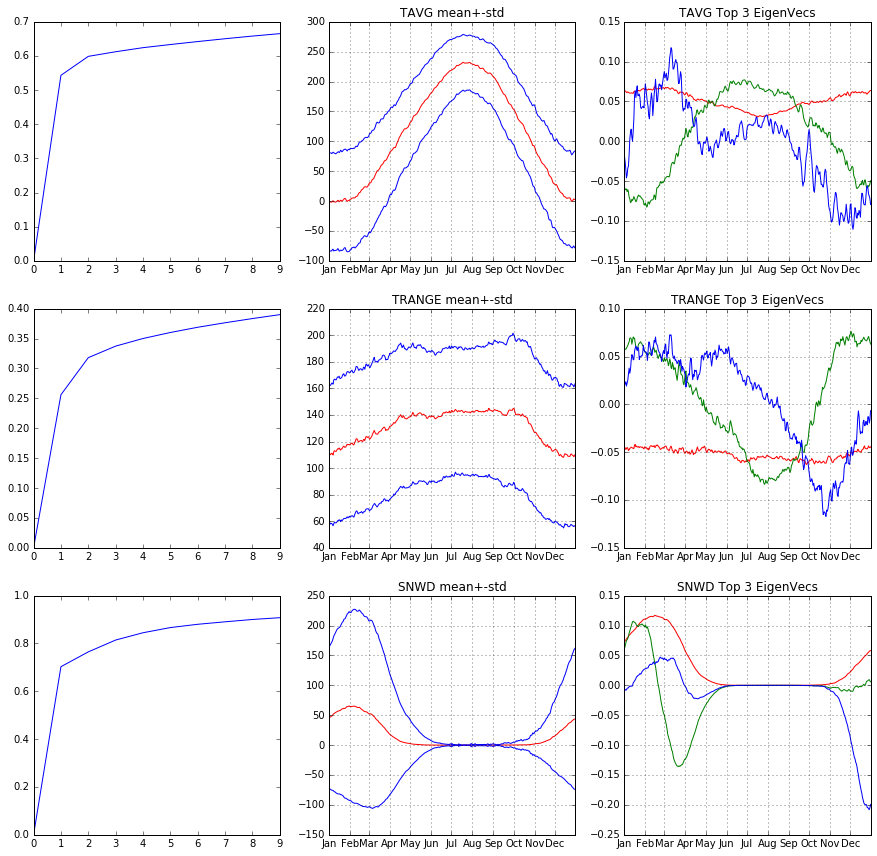

In [41]:
## ploting the top 3 eigen vectors for TRANGE, TAVG, and SNWD for interpretation of the eigenvectors ##
figure(figsize=(15,30))
offset=1
for meas in STAT.keys():
    subplot(6,3,offset)
    offset+=1
    ## Your code for percentage of variance explained
    perc_var_exp=[]
    eig_top_10=sorted(STAT[meas]['eigval'], reverse=True)[0:10]
    for i in range(10):
        perc_var_exp.append(sum(eig_top_10[:i]))
    plt.plot(perc_var_exp/STAT[meas]['eigval'].sum())
    subplot(6,3,offset)
    offset+=1
    ## Your code for mean and mean +- std
    YearlyPlots(STAT[meas]['Mean'],ttl=meas+' mean+-std',yl='',xl='',y=None,x=None,size=(10,7), c='red')
    YearlyPlots(STAT[meas]['Mean']+sqrt(STAT[meas]['Var']),ttl=meas+' mean+-std',yl='',xl='',y=None,x=None,size=(10,7), c='blue')
    YearlyPlots(STAT[meas]['Mean']-sqrt(STAT[meas]['Var']),ttl=meas+' mean+-std',yl='',xl='',y=None,x=None,size=(10,7), c='blue')
    subplot(6,3,offset)
    offset+=1
    ## Your code for top-3 eigenvectors    
    YearlyPlots(STAT[meas]['eigvec'][:,0],ttl=meas+' Top 3 EigenVecs',yl='',xl='',y=None,x=None,size=(10,7), c='red')
    YearlyPlots(STAT[meas]['eigvec'][:,1],ttl=meas+' Top 3 EigenVecs',yl='',xl='',y=None,x=None,size=(10,7), c='green')
    YearlyPlots(STAT[meas]['eigvec'][:,2],ttl=meas+' Top 3 EigenVecs',yl='',xl='',y=None,x=None,size=(10,7), c='blue')

subplot(6,3,offset)
offset+=1
## Your code for percentage of variance explained
perc_var_exp=[]
meas='SNWD'
eig_top_10=sorted(STAT_SNWD[meas]['eigval'], reverse=True)[0:10]
for i in range(10):
    perc_var_exp.append(sum(eig_top_10[:i]))
plt.plot(perc_var_exp/STAT_SNWD[meas]['eigval'].sum())
subplot(6,3,offset)
offset+=1
## Your code for mean and mean +- std
YearlyPlots(STAT_SNWD[meas]['Mean'],ttl=meas+' mean+-std',yl='',xl='',y=None,x=None,size=(10,7), c='red')
YearlyPlots(STAT_SNWD[meas]['Mean']+sqrt(STAT_SNWD[meas]['Var']),ttl=meas+' mean+-std',yl='',xl='',y=None,x=None,size=(10,7), c='blue')
YearlyPlots(STAT_SNWD[meas]['Mean']-sqrt(STAT_SNWD[meas]['Var']),ttl=meas+' mean+-std',yl='',xl='',y=None,x=None,size=(10,7), c='blue')
subplot(6,3,offset)
offset+=1
## Your code for top-3 eigenvectors    
YearlyPlots(STAT_SNWD[meas]['eigvec'][:,0],ttl=meas+' Top 3 EigenVecs',yl='',xl='',y=None,x=None,size=(10,7), c='red')
YearlyPlots(STAT_SNWD[meas]['eigvec'][:,1],ttl=meas+' Top 3 EigenVecs',yl='',xl='',y=None,x=None,size=(10,7), c='green')
YearlyPlots(STAT_SNWD[meas]['eigvec'][:,2],ttl=meas+' Top 3 EigenVecs',yl='',xl='',y=None,x=None,size=(10,7), c='blue')

In [37]:
## defining a simple plot function
def plot_coeff(x,y):
    plt.scatter(data[x], data[y])
    plt.title(x+' vs '+y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

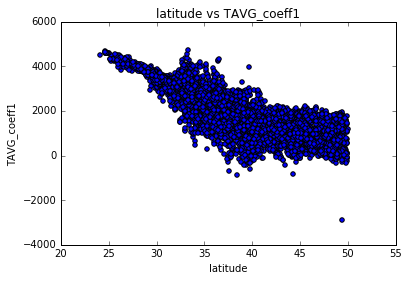

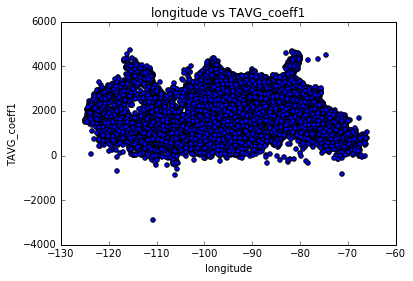

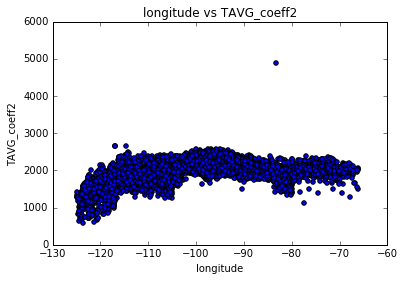

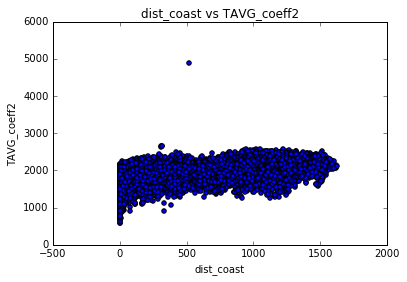

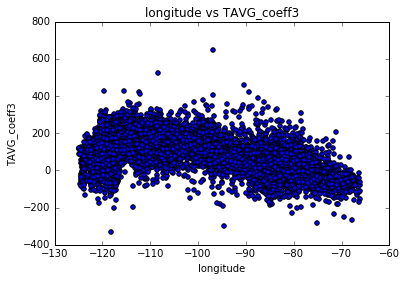

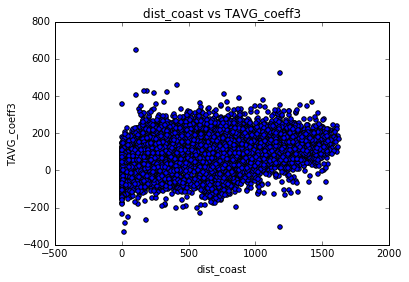

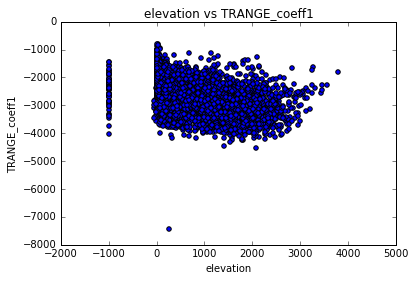

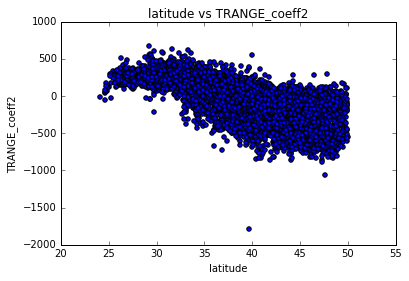

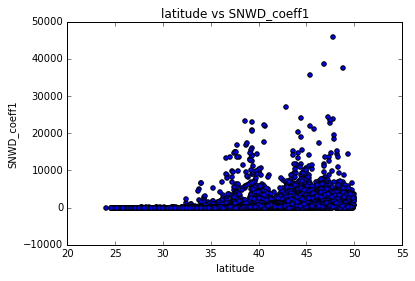

In [39]:
##plotting the coefficient vs data to interpret the 9 relationship above##
plot_coeff('latitude','TAVG_coeff1')
plot_coeff('longitude','TAVG_coeff1')
plot_coeff('longitude','TAVG_coeff2')
plot_coeff('dist_coast','TAVG_coeff2')
plot_coeff('longitude','TAVG_coeff3')
plot_coeff('dist_coast','TAVG_coeff3')
plot_coeff('elevation','TRANGE_coeff1')
plot_coeff('latitude','TRANGE_coeff2')
plot_coeff('latitude','SNWD_coeff1')